# Trading vs. Weather Analysis

**Author**: Atakan Vardar  
**Date**: January 2025  

---

## Table of Contents
1. Introduction  
2. Data Reading  
3. Data Preprocessing  
4. Feature Engineering  
5. Exploratory Data Analysis (EDA)  
   1. Profit Distribution  
   2. Weather Variables  
   3. Time-Based Analysis (Daily)  
   4. Monthly Analysis (Temperature vs. Win Rate)  
6. Statistical Tests  
   1. Rain vs. Non-Rain t-test  
   2. ANOVA & Kruskal–Wallis (Day of Week)  
   3. Monthly Temperature vs. Win Rate Correlation  
7. Simple Regression (Optional)  
8. Key Findings & Observations   
9. End of Notebook

---


## 1. Introduction

This notebook merges **personal trading data** with **local Istanbul weather data** to investigate whether external factors—like temperature, precipitation, or time-of-day—are related to trading outcomes (profit or loss).

**Disclaimer**: This analysis is purely exploratory and should not be relied upon for actual trading decisions.  


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Configure pandas and seaborn display
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
sns.set_theme(style='darkgrid')

# For reproducibility in certain calculations
np.random.seed(42)

print("Libraries imported and initial settings configured.")


Libraries imported and initial settings configured.


# 2. Data Reading

 We will read in two CSV files:
 1) trading_results_summary.csv (personal trading logs)
 2) Istanbul,Turkey 2023-08-18 to 2024-12-18.csv (weather data for Istanbul)

In [59]:
# Adjust file paths as needed
trading_df = pd.read_csv(
    'data/trading_results_summary.csv',
    parse_dates=['Open_Time', 'Close_Time']
)

weather_df = pd.read_csv(
    'data/Istanbul,Turkey 2023-08-18 to 2024-12-18.csv',
    parse_dates=['datetime']
)

print("Trading DataFrame Shape:", trading_df.shape)
print("Weather DataFrame Shape:", weather_df.shape)

# Quick preview
trading_df.head()

Trading DataFrame Shape: (290, 14)
Weather DataFrame Shape: (489, 33)


,#,Open_Time,Direction,Entry_Price,Stop_Loss,Take_Profit,RR,Balance_Before,Risk_Amount,Position_Size,Close_Time,Balance_After,Profit,Result
0,1,2023-08-18 17:20:00,Long,1.08704,1.08704,1.08704,2,10000,100,NaN,2023-08-18 17:20:00,10200,200,Win
1,2,2023-08-21 12:20:00,Long,1.09003,1.08996,1.09017,2,10200,100,NaN,2023-08-21 12:20:00,10400,200,Win
2,3,2023-08-22 12:35:00,Long,1.08803,1.08757,1.08895,2,10400,100,NaN,2023-08-22 12:35:00,10300,-100,Lose
3,4,2023-08-23 12:25:00,Long,1.08056,1.08044,1.08080,2,10300,100,NaN,2023-08-23 12:25:00,10300,0,BreakEven
4,5,2023-08-24 11:40:00,Long,1.08496,1.08496,1.08496,2,10300,100,NaN,2023-08-24 11:40:00,10500,200,Win


In [60]:
# In[3]: Quick Preview of Weather Data

weather_df.head()


,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Istanbul,Turkey",2023-08-18,28.4,24.7,26.3,32.4,24.7,27.6,22.4,79.4,0.0,0,0.0,NaN,0.0,0.0,59.8,29.9,47.4,1011.2,46.2,13.2,140.3,12.1,9,NaN,2023-08-18T06:16:12,2023-08-18T19:59:09,0.07,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"D8508,LTBA,17063099999,17119099999,17061099999..."
1,"Istanbul,Turkey",2023-08-19,28.3,24.8,26.4,31.7,24.8,27.6,22.0,76.7,0.0,0,0.0,NaN,0.0,0.0,58.3,31.0,50.3,1011.7,53.8,13.2,196.3,17.3,10,NaN,2023-08-19T06:17:12,2023-08-19T19:57:42,0.10,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"D8508,LTBA,17063099999,17119099999,17061099999..."
2,"Istanbul,Turkey",2023-08-20,29.5,23.7,26.6,33.2,23.7,28.0,21.8,75.8,0.0,0,0.0,NaN,0.0,0.0,48.6,25.2,36.5,1012.8,30.6,13.2,203.5,17.5,8,NaN,2023-08-20T06:18:12,2023-08-20T19:56:14,0.14,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"D8508,LTBA,17063099999,17119099999,17061099999..."
3,"Istanbul,Turkey",2023-08-21,30.4,23.7,26.7,33.2,23.7,28.2,22.2,77.4,0.0,0,0.0,NaN,0.0,0.0,42.1,22.6,40.4,1013.0,30.5,13.2,196.7,17.0,8,NaN,2023-08-21T06:19:12,2023-08-21T19:54:45,0.17,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"D8508,LTBA,17063099999,17119099999,17061099999..."
4,"Istanbul,Turkey",2023-08-22,30.8,23.8,27.2,33.0,23.8,28.6,21.7,73.3,0.0,0,0.0,NaN,0.0,0.0,42.1,22.0,40.5,1014.0,13.8,12.9,197.4,16.9,8,NaN,2023-08-22T06:20:12,2023-08-22T19:53:15,0.20,Clear,Clear conditions throughout the day.,clear-day,"D8508,LTBA,17063099999,17119099999,17061099999..."


## 3. Data Preprocessing

1. Convert `Open_Time` → daily `Date` in trading data.  
2. Rename weather’s `datetime` → `Date`, normalize to midnight.  
3. Merge the two DataFrames on `Date` (inner join).


In [61]:
# Trading Data: create a 'Date' column (day-level)
trading_df['Date'] = trading_df['Open_Time'].dt.date
trading_df['Date'] = pd.to_datetime(trading_df['Date'])

# Weather Data: rename 'datetime' -> 'Date' and normalize
weather_df.rename(columns={'datetime': 'Date'}, inplace=True)
weather_df['Date'] = weather_df['Date'].dt.normalize()

# Merge on 'Date'
merged_df = pd.merge(trading_df, weather_df, on='Date', how='inner')

print("Merged DataFrame shape:", merged_df.shape)
merged_df.head()


Merged DataFrame shape: (290, 47)


,#,Open_Time,Direction,Entry_Price,Stop_Loss,Take_Profit,RR,Balance_Before,Risk_Amount,Position_Size,Close_Time,Balance_After,Profit,Result,Date,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,1,2023-08-18 17:20:00,Long,1.08704,1.08704,1.08704,2,10000,100,NaN,2023-08-18 17:20:00,10200,200,Win,2023-08-18,"Istanbul,Turkey",28.4,24.7,26.3,32.4,24.7,27.6,22.4,79.4,0.0,0,0.0,NaN,0.0,0.0,59.8,29.9,47.4,1011.2,46.2,13.2,140.3,12.1,9,NaN,2023-08-18T06:16:12,2023-08-18T19:59:09,0.07,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"D8508,LTBA,17063099999,17119099999,17061099999..."
1,2,2023-08-21 12:20:00,Long,1.09003,1.08996,1.09017,2,10200,100,NaN,2023-08-21 12:20:00,10400,200,Win,2023-08-21,"Istanbul,Turkey",30.4,23.7,26.7,33.2,23.7,28.2,22.2,77.4,0.0,0,0.0,NaN,0.0,0.0,42.1,22.6,40.4,1013.0,30.5,13.2,196.7,17.0,8,NaN,2023-08-21T06:19:12,2023-08-21T19:54:45,0.17,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"D8508,LTBA,17063099999,17119099999,17061099999..."
2,3,2023-08-22 12:35:00,Long,1.08803,1.08757,1.08895,2,10400,100,NaN,2023-08-22 12:35:00,10300,-100,Lose,2023-08-22,"Istanbul,Turkey",30.8,23.8,27.2,33.0,23.8,28.6,21.7,73.3,0.0,0,0.0,NaN,0.0,0.0,42.1,22.0,40.5,1014.0,13.8,12.9,197.4,16.9,8,NaN,2023-08-22T06:20:12,2023-08-22T19:53:15,0.20,Clear,Clear conditions throughout the day.,clear-day,"D8508,LTBA,17063099999,17119099999,17061099999..."
3,4,2023-08-23 12:25:00,Long,1.08056,1.08044,1.08080,2,10300,100,NaN,2023-08-23 12:25:00,10300,0,BreakEven,2023-08-23,"Istanbul,Turkey",30.0,24.1,27.1,34.0,24.1,28.9,22.4,76.2,0.0,0,0.0,NaN,0.0,0.0,48.2,23.4,46.4,1013.8,27.1,13.1,183.4,15.5,8,NaN,2023-08-23T06:21:12,2023-08-23T19:51:44,0.24,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,"D8508,LTBA,17063099999,17119099999,17061099999..."
4,5,2023-08-24 11:40:00,Long,1.08496,1.08496,1.08496,2,10300,100,NaN,2023-08-24 11:40:00,10500,200,Win,2023-08-24,"Istanbul,Turkey",30.1,24.4,26.7,32.6,24.4,27.9,21.8,75.2,0.0,0,0.0,NaN,0.0,0.0,42.5,27.0,47.0,1013.2,30.8,12.3,271.7,23.5,8,NaN,2023-08-24T06:22:12,2023-08-24T19:50:13,0.25,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"D8508,LTBA,17063099999,17119099999,17061099999..."


## 4. Feature Engineering

We add columns:
- `rain_indicator`: 1 if `precip` > 0 else 0  
- `temp_range`: `tempmax - tempmin`  
- `day_of_week` (0=Mon ... 6=Sun)  
- `hour_of_day` (extracted from `Open_Time`)  
- `trade_duration_min`: (Close_Time - Open_Time) in minutes  


In [62]:
merged_df['rain_indicator'] = (merged_df['precip'] > 0).astype(int)
merged_df['temp_range'] = merged_df['tempmax'] - merged_df['tempmin']
merged_df['day_of_week'] = merged_df['Date'].dt.dayofweek
merged_df['hour_of_day'] = merged_df['Open_Time'].dt.hour
merged_df['trade_duration_min'] = (
    merged_df['Close_Time'] - merged_df['Open_Time']
).dt.total_seconds() / 60.0

merged_df.head()


,#,Open_Time,Direction,Entry_Price,Stop_Loss,Take_Profit,RR,Balance_Before,Risk_Amount,Position_Size,Close_Time,Balance_After,Profit,Result,Date,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations,rain_indicator,temp_range,day_of_week,hour_of_day,trade_duration_min
0,1,2023-08-18 17:20:00,Long,1.08704,1.08704,1.08704,2,10000,100,NaN,2023-08-18 17:20:00,10200,200,Win,2023-08-18,"Istanbul,Turkey",28.4,24.7,26.3,32.4,24.7,27.6,22.4,79.4,0.0,...,NaN,0.0,0.0,59.8,29.9,47.4,1011.2,46.2,13.2,140.3,12.1,9,NaN,2023-08-18T06:16:12,2023-08-18T19:59:09,0.07,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"D8508,LTBA,17063099999,17119099999,17061099999...",0,3.7,4,17,0.0
1,2,2023-08-21 12:20:00,Long,1.09003,1.08996,1.09017,2,10200,100,NaN,2023-08-21 12:20:00,10400,200,Win,2023-08-21,"Istanbul,Turkey",30.4,23.7,26.7,33.2,23.7,28.2,22.2,77.4,0.0,...,NaN,0.0,0.0,42.1,22.6,40.4,1013.0,30.5,13.2,196.7,17.0,8,NaN,2023-08-21T06:19:12,2023-08-21T19:54:45,0.17,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"D8508,LTBA,17063099999,17119099999,17061099999...",0,6.7,0,12,0.0
2,3,2023-08-22 12:35:00,Long,1.08803,1.08757,1.08895,2,10400,100,NaN,2023-08-22 12:35:00,10300,-100,Lose,2023-08-22,"Istanbul,Turkey",30.8,23.8,27.2,33.0,23.8,28.6,21.7,73.3,0.0,...,NaN,0.0,0.0,42.1,22.0,40.5,1014.0,13.8,12.9,197.4,16.9,8,NaN,2023-08-22T06:20:12,2023-08-22T19:53:15,0.20,Clear,Clear conditions throughout the day.,clear-day,"D8508,LTBA,17063099999,17119099999,17061099999...",0,7.0,1,12,0.0
3,4,2023-08-23 12:25:00,Long,1.08056,1.08044,1.08080,2,10300,100,NaN,2023-08-23 12:25:00,10300,0,BreakEven,2023-08-23,"Istanbul,Turkey",30.0,24.1,27.1,34.0,24.1,28.9,22.4,76.2,0.0,...,NaN,0.0,0.0,48.2,23.4,46.4,1013.8,27.1,13.1,183.4,15.5,8,NaN,2023-08-23T06:21:12,2023-08-23T19:51:44,0.24,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,"D8508,LTBA,17063099999,17119099999,17061099999...",0,5.9,2,12,0.0
4,5,2023-08-24 11:40:00,Long,1.08496,1.08496,1.08496,2,10300,100,NaN,2023-08-24 11:40:00,10500,200,Win,2023-08-24,"Istanbul,Turkey",30.1,24.4,26.7,32.6,24.4,27.9,21.8,75.2,0.0,...,NaN,0.0,0.0,42.5,27.0,47.0,1013.2,30.8,12.3,271.7,23.5,8,NaN,2023-08-24T06:22:12,2023-08-24T19:50:13,0.25,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"D8508,LTBA,17063099999,17119099999,17061099999...",0,5.7,3,11,0.0


### Quick Descriptive Statistics

We can view overall stats of key columns: `Profit`, `temp`, `humidity`, etc.


In [63]:
merged_df.describe()


,#,Entry_Price,Stop_Loss,Take_Profit,RR,Balance_Before,Risk_Amount,Position_Size,Balance_After,Profit,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,rain_indicator,temp_range,day_of_week,hour_of_day,trade_duration_min
count,290.000000,290.000000,290.000000,290.000000,290.0,290.000000,290.0,0.0,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.0,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,0.0,290.000000,290.000000,290.000000,290.000000,290.000000,290.0
mean,145.500000,1.080864,1.080736,1.081120,2.0,21241.379310,100.0,NaN,21324.482759,83.103448,21.082069,14.575862,17.590690,21.302414,14.090000,17.507586,12.343448,72.923448,1.775345,43.448276,4.066172,0.0,0.000345,36.156897,20.555517,115.071379,1015.588276,48.411379,11.350000,141.953448,12.253448,5.731034,NaN,0.477931,0.434483,6.506207,2.024138,11.755172,0.0
std,83.860002,0.016265,0.016269,0.016262,0.0,6999.026983,0.0,NaN,7008.160387,142.241168,7.374201,6.262856,6.613906,8.062315,6.920858,7.327500,5.559472,9.325146,5.805432,49.654576,6.652888,0.0,0.005872,10.845070,6.597592,110.249963,5.982657,27.130041,1.515645,80.670499,6.980061,2.504681,NaN,0.286936,0.496546,2.409934,1.415230,3.369730,0.0
min,1.000000,1.047510,1.047430,1.047670,2.0,10000.000000,100.0,NaN,10200.000000,-100.000000,5.200000,2.100000,4.500000,2.500000,-2.000000,-0.100000,-3.400000,44.500000,0.000000,0.000000,0.000000,0.0,0.000000,14.800000,7.900000,0.500000,1000.200000,0.000000,6.500000,9.200000,0.800000,1.000000,NaN,0.000000,0.000000,1.400000,0.000000,8.000000,0.0
25%,73.250000,1.070415,1.070407,1.070522,2.0,14525.000000,100.0,NaN,14600.000000,-100.000000,15.200000,9.500000,12.225000,15.200000,8.025000,12.050000,8.200000,66.400000,0.000000,0.000000,0.000000,0.0,0.000000,28.175000,16.125000,34.575000,1011.500000,26.525000,10.700000,75.725000,6.525000,4.000000,NaN,0.242500,0.000000,4.625000,1.000000,9.000000,0.0
50%,145.500000,1.081700,1.081590,1.082145,2.0,20450.000000,100.0,NaN,20500.000000,200.000000,20.550000,14.200000,17.050000,20.550000,14.200000,17.050000,12.000000,72.600000,0.000000,0.000000,0.000000,0.0,0.000000,34.600000,20.000000,47.850000,1015.150000,47.750000,11.000000,135.500000,11.600000,6.000000,NaN,0.470000,0.000000,6.700000,2.000000,11.000000,0.0
75%,217.750000,1.090903,1.090743,1.091160,2.0,28175.000000,100.0,NaN,28350.000000,200.000000,27.375000,20.725000,24.125000,28.450000,20.725000,24.200000,17.075000,80.725000,0.603000,100.000000,8.330000,0.0,0.000000,42.800000,25.300000,229.200000,1018.800000,71.875000,12.000000,208.600000,17.975000,8.000000,NaN,0.737500,1.000000,8.200000,3.000000,14.000000,0.0
max,290.000000,1.119190,1.118990,1.119590,2.0,34100.000000,100.0,NaN,34100.000000,200.000000,36.100000,26.500000,30.200000,40.600000,26.500000,33.500000,23.600000,94.800000,68.193000,100.000000,70.830000,0.0,0.100000,80.300000,42.200000,360.000000,1032.400000,96.300000,20.000000,351.800000,30.300000,10.000000,NaN,0.980000,1.000000,12.400000,4.000000,20.000000,0.0


## 5. Exploratory Data Analysis (EDA)

**Goal**: Understand the overall distribution of profit, check weather patterns, and see if there are visible time-based effects.


### 5.1 Profit Distribution


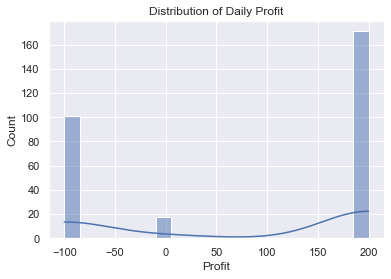

In [64]:
plt.figure(figsize=(6,4))
sns.histplot(data=merged_df, x='Profit', bins=20, kde=True)
plt.title("Distribution of Daily Profit")
plt.show()


### 5.2 Weather Variables


Distribution of Temperature

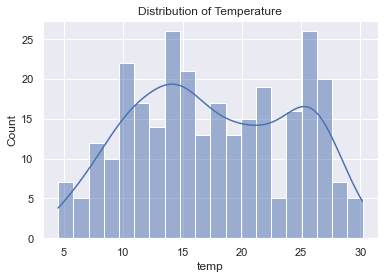

In [65]:
plt.figure(figsize=(6,4))
sns.histplot(data=merged_df, x='temp', bins=20, kde=True)
plt.title("Distribution of Temperature")
plt.show()


Boxplot: Profit on Rainy vs. Non-Rainy Days


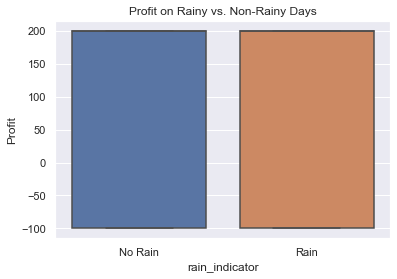

In [48]:
plt.figure(figsize=(6,4))
sns.boxplot(data=merged_df, x='rain_indicator', y='Profit')
plt.xticks([0, 1], ['No Rain', 'Rain'])
plt.title("Profit on Rainy vs. Non-Rainy Days")
plt.show()


Correlation Matrix

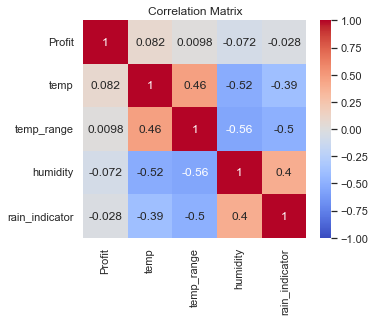

In [67]:
corr_cols = ['Profit', 'temp', 'temp_range', 'humidity', 'rain_indicator']
corr_matrix = merged_df[corr_cols].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


### Observations from the Correlation Matrix

- `Profit` has weak correlations with `temp`, `temp_range`, `humidity`, and `rain_indicator`.
- Weather variables inter-correlate (e.g., `temp_range` is related to `temp`, etc.).


### 5.3 Time-Based Analysis (Daily)


Average Profit by Day of Week

Mean & Count of Profit by Day of Week:


,mean,count
day_of_week,,
0,50.909091,55
1,71.666667,60
2,94.915254,59
3,87.272727,55
4,108.196721,61


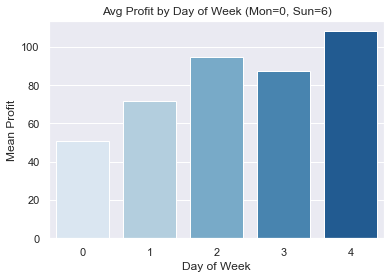

In [69]:
dow_stats = merged_df.groupby('day_of_week')['Profit'].agg(['mean','count'])
print("Mean & Count of Profit by Day of Week:")
display(dow_stats)

plt.figure(figsize=(6,4))
sns.barplot(x=dow_stats.index, y=dow_stats['mean'], palette='Blues')
plt.title("Avg Profit by Day of Week (Mon=0, Sun=6)")
plt.xlabel("Day of Week")
plt.ylabel("Mean Profit")
plt.show()


Win Rate by Day of Week

Win Rate by Day of Week (%):


day_of_week
0    47.272727
1    55.000000
2    62.711864
3    60.000000
4    68.852459
Name: win_binary, dtype: float64

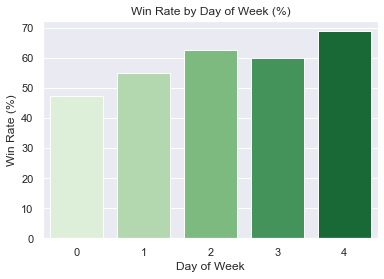

In [70]:
if 'win_binary' not in merged_df.columns:
    merged_df['win_binary'] = merged_df['Result'].apply(lambda x: 1 if x=='Win' else 0)

dow_winrate = merged_df.groupby('day_of_week')['win_binary'].mean() * 100

print("Win Rate by Day of Week (%):")
display(dow_winrate)

plt.figure(figsize=(6,4))
sns.barplot(x=dow_winrate.index, y=dow_winrate.values, palette='Greens')
plt.title("Win Rate by Day of Week (%)")
plt.xlabel("Day of Week")
plt.ylabel("Win Rate (%)")
plt.show()


Average Profit by Hour of Day

Profit stats by hour_of_day:


,mean,count
hour_of_day,,
8,66.666667,54
9,83.333333,42
10,66.666667,39
11,109.677419,31
12,88.888889,27
13,45.454545,11
14,65.000000,20
15,75.000000,16
16,100.000000,9


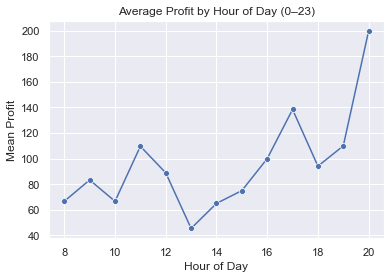

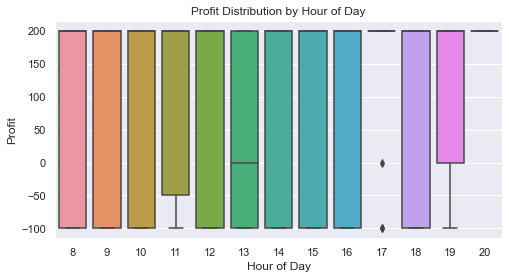

In [71]:
hourly_stats = merged_df.groupby('hour_of_day')['Profit'].agg(['mean','count'])
print("Profit stats by hour_of_day:")
display(hourly_stats)

plt.figure(figsize=(6,4))
sns.lineplot(x=hourly_stats.index, y=hourly_stats['mean'], marker='o')
plt.title("Average Profit by Hour of Day (0–23)")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Profit")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(data=merged_df, x='hour_of_day', y='Profit')
plt.title("Profit Distribution by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Profit")
plt.show()


### 5.4 Monthly Analysis (Temperature vs. Win Rate)

We'll examine whether monthly temperature trends correlate with monthly win rates (percentage of winning trades).


Monthly Temperature & Win Rate

In [72]:
df_ts = merged_df.set_index('Open_Time').sort_index()

# Monthly mean temperature
monthly_temp = df_ts['temp'].resample('M').mean()

# Monthly win rate (mean of win_binary * 100)
monthly_winrate = df_ts['win_binary'].resample('M').mean() * 100

df_monthly = pd.DataFrame({
    'avg_temp': monthly_temp,
    'win_rate': monthly_winrate
}).dropna()

print("Monthly DataFrame shape:", df_monthly.shape)
df_monthly.head()


Monthly DataFrame shape: (17, 2)


,avg_temp,win_rate
Open_Time,,
2023-08-31,26.670000,80.000000
2023-09-30,22.761111,55.555556
2023-10-31,18.611765,41.176471
2023-11-30,14.925000,45.000000
2023-12-31,11.111765,52.941176


Plot Monthly Temperature vs. Monthly Win Rate

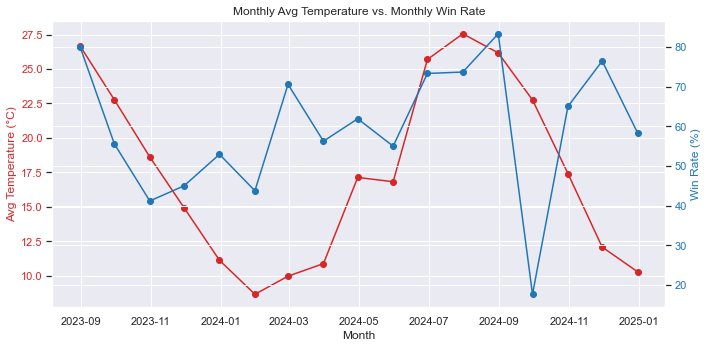

In [73]:
fig, ax1 = plt.subplots(figsize=(10,5))

color1 = 'tab:red'
ax1.set_xlabel("Month")
ax1.set_ylabel("Avg Temperature (°C)", color=color1)
ax1.plot(df_monthly.index, df_monthly['avg_temp'], marker='o', color=color1, label='Avg Temp')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel("Win Rate (%)", color=color2)
ax2.plot(df_monthly.index, df_monthly['win_rate'], marker='o', color=color2, label='Win Rate')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Monthly Avg Temperature vs. Monthly Win Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Statistical Tests

We conduct:
1. Rain vs. Non-Rain (Two-Sample t-test)  
2. Day of Week (ANOVA & Kruskal–Wallis)  
3. Monthly Temperature vs. Win Rate Correlation (Pearson & Spearman)


6.1 Rain vs. Non-Rain (Two-Sample t-test)

In [74]:
rainy_profits = merged_df.loc[merged_df['rain_indicator']==1, 'Profit']
dry_profits = merged_df.loc[merged_df['rain_indicator']==0, 'Profit']

tstat, pval = stats.ttest_ind(rainy_profits, dry_profits, equal_var=False)
print("Rain vs. Non-Rain t-test:")
print("  t-statistic =", tstat)
print("  p-value =", pval)

Rain vs. Non-Rain t-test:
  t-statistic = -0.47459433745508967
  p-value = 0.6354621850376987


6.2 ANOVA & Kruskal-Wallis (Day of Week)

In [75]:
groups = [grp['Profit'].values for _, grp in merged_df.groupby('day_of_week')]

fstat, p_value = stats.f_oneway(*groups)
print("ANOVA (day_of_week):")
print("  F-stat =", fstat)
print("  p-value =", p_value)

h_stat, kw_pval = stats.kruskal(*groups)
print("\nKruskal–Wallis (day_of_week):")
print("  H-stat =", h_stat)
print("  p-value =", kw_pval)

ANOVA (day_of_week):
  F-stat = 1.3971298469531974
  p-value = 0.23504187810123675

Kruskal–Wallis (day_of_week):
  H-stat = 5.415274437125298
  p-value = 0.24727791494784812


6.3 Monthly Temp vs. Win Rate (Pearson & Spearman)

In [77]:
pearson_corr, pearson_p = stats.pearsonr(df_monthly['avg_temp'], df_monthly['win_rate'])
spearman_corr, spearman_p = stats.spearmanr(df_monthly['avg_temp'], df_monthly['win_rate'])

print("Monthly Temperature vs. Win Rate Correlation:")
print(f"  Pearson Correlation = {pearson_corr:.4f}, p-value = {pearson_p:.4g}")
print(f"  Spearman Correlation = {spearman_corr:.4f}, p-value = {spearman_p:.4g}")



Monthly Temperature vs. Win Rate Correlation:
  Pearson Correlation = 0.2641, p-value = 0.3057
  Spearman Correlation = 0.3824, p-value = 0.1299


## 7. Simple Regression

In [78]:
features = ['temp', 'humidity', 'temp_range', 'rain_indicator', 'day_of_week', 'hour_of_day']
X = merged_df[features]
y = merged_df['Profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Linear Regression R^2:", r2)
print("RMSE:", rmse)


Linear Regression R^2: 0.033354107370092256
RMSE: 141.16617332140376


## 8. Key Findings & Interpretations

1. **Rain vs. Non-Rain (Two-Sample t-test)**
   - **Null Hypothesis (H₀)**: There is **no difference** in average Profit between rainy days and non-rainy days.
   - **Test Results**:
     - *t-statistic* = **-0.4746**
     - *p-value* = **0.6355**
   - **Interpretation**: Since p > 0.05, we **fail to reject** H₀. Our data do **not** provide evidence that average Profit differs between rainy and non-rainy days.

2. **Day of Week (ANOVA & Kruskal–Wallis)**
   - **Null Hypothesis (H₀)**: The **mean Profit** is the same across all weekdays (Monday through Sunday).
   - **ANOVA**
     - *F-stat* = **1.3971**, *p-value* = **0.2350**
     - Conclusion: p > 0.05 → **fail to reject** H₀.
   - **Kruskal–Wallis** (non-parametric)
     - *H-stat* = **5.4153**, *p-value* = **0.2473**
     - Conclusion: p > 0.05 → **fail to reject** H₀.
   - **Interpretation**: Both tests indicate **no significant difference** in mean Profit across weekdays. While some days (e.g., Friday) might show visually higher profits, these differences are **not** statistically confirmed given the current sample size.

3. **Monthly Temperature vs. Win Rate (Pearson & Spearman Correlation)**
   - **Null Hypothesis (H₀)**: There is **no linear** (Pearson) or **monotonic** (Spearman) relationship between monthly average temperature and monthly win rate.
   - **Test Results**:
     - Pearson Correlation = **0.2641**, p-value = **0.3057**
     - Spearman Correlation = **0.3824**, p-value = **0.1299**
   - **Interpretation**: Both p-values exceed 0.05, so we **fail to reject** H₀. No statistically significant correlation is found, indicating **no strong evidence** that monthly temperature and monthly win rate move together in a linear or monotonic fashion.

---

### Overall Conclusions

1. **No Evidence of Rain Impact**  
   Rain vs. non-rain days do not show a statistically significant difference in average Profit.

2. **No Significant Day-of-Week Effect**  
   Although certain weekdays appear to have higher mean profits or win rates, both ANOVA and Kruskal–Wallis yield p > 0.05, indicating no statistically supported weekday-based effect.

3. **No Significant Monthly Temperature–Win Rate Correlation**  
   Pearson and Spearman correlation tests (p > 0.05) suggest no strong linear or monotonic relationship between monthly temperature changes and monthly win rates.

All results should be interpreted in the context of:
- **Sample Size** and potential **time-series autocorrelation**.
- **Unexplored Variables** (e.g., market news, personal schedule) that might overshadow weather/time influences.


# End of Notebook

Thank you for exploring this analysis! Feel free to modify or add your own sections for deeper insights.
